# Modeling Bus Ridership in San Diego
### Torben Noto
##### San Diego Smartcity Hackathon 2016

In [3]:
#importing modules
%config InlineBackend.figure_format = 'retina'
%pylab inline
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


## Problem:
Bus routes and times are not optimized and users are unhappy with the service. 
This might be improved if we can model and visualize the data. The usage of bus routes is known anecdotally but not quantifiably.

## Assumptions:
### The following features are evedant and important to effective bus usage:
* Overall demand of a given bus route
* Surging demand for certain bus routes
* (Simplification) Bus stops are equidistanct

## Goals:
* Demonstrate that these features can be used to model bus use data
* Estimate surging and demand of bus routes using only passenger counts



In [4]:
def sim_demand(timesteps,n_surges,surge_shift = 0, surge_coeff = 0,noise_coeff = 0,demand_coeff = 10,max_cap = 40):
    """
    Models the fluctuating demand for bus service over time as a function of demand, surges, and noise.
    
    Inputs:
    timesteps: a 1 x N array of timepoints where each point is a bus stop
    n_surges: (0-N int) number of surges per time period to model
    surge_coeff: (0-1 float)How much to weight importance of surge to model
    noise_coeff: (0-1 float) How much to weight importance of noise to model
    total_demand: (int) How much a certain bus route is demanded by passengers

    Returns:
    demand_vect: 1 x N delta function of number of times a bus reached it's max capacity
    passenger_vect: 1 x N plot of number of passengers on a bus at any time point
    """
    
    #hacky handling /0 error
    if n_surges == 0:
        n_surges = 0.0001 
    
    #modeling surges in bus demand with sin waves
    surge_component = surge_coeff*np.sin(timesteps/((len(timesteps)/(2*np.pi))/(n_surges))+surge_shift) 
    #modeling unpredictability in bus demand with white noise
    noise_component = (noise_coeff*(np.random.rand((len(timesteps)))-0.5)*2)
    
    #combine surge and noise components to simulate realistic demand
    demand_vect = surge_component+noise_component
    #zscore so changing surge and noise components doesn't affect total demand
    demand_vect = (demand_vect*np.mean(demand_vect))/np.std(demand_vect)
    #demand_coeff determines how many times the bus fills up
    if demand_coeff>=0:
        stretch = [i for i in reversed(sorted(demand_vect))][demand_coeff]
        stretch = max_cap/stretch
        demand_vect = demand_vect*stretch
        
    else:
        stretch = [i for i in reversed(sorted(demand_vect))][0]
        stretch = max_cap/stretch
        demand_vect = (demand_vect*stretch)+demand_coeff
    
    passenger_vect = np.zeros(len(timesteps))
    alarm_vect = np.zeros(len(timesteps))
    
    for x,y in enumerate(demand_vect):
        if y > 0:
            passenger_vect[x] = np.floor(y)
        if y>=max_cap:
            alarm_vect[x] = 1
    passenger_vect[passenger_vect > max_cap] = max_cap
    
    return alarm_vect,passenger_vect


### Demonstrating the the simulation does what I expect

(0, 40)

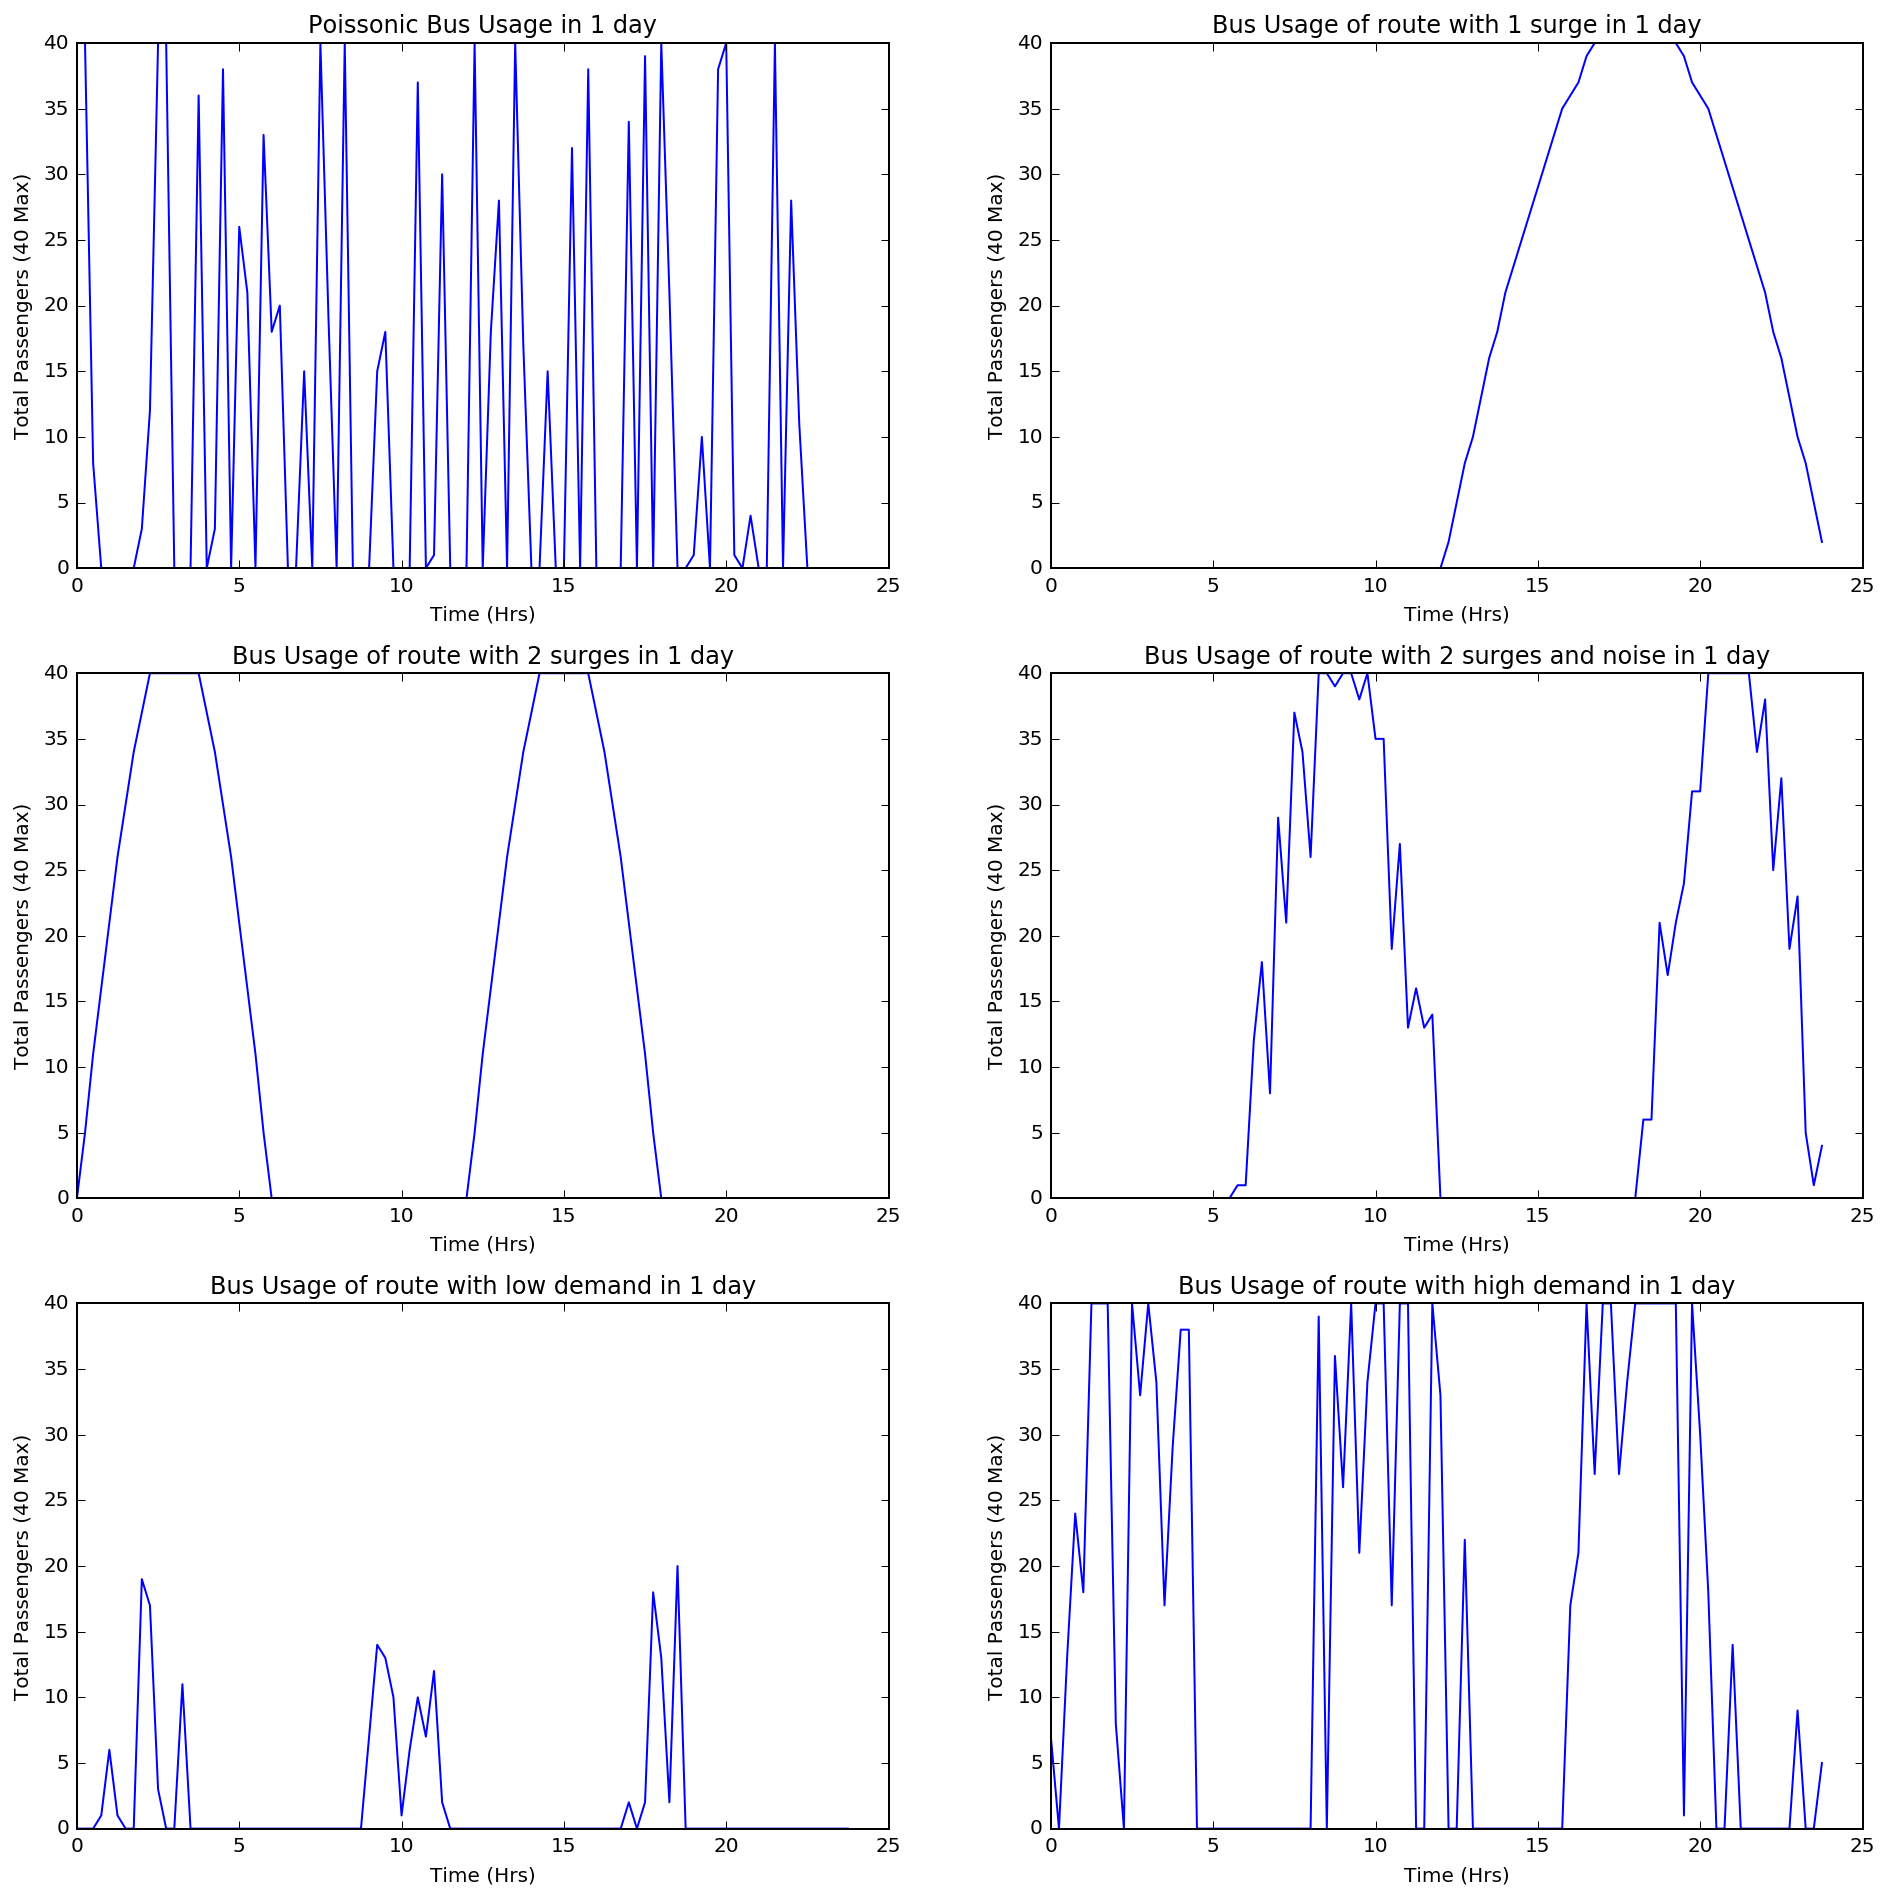

In [5]:
#static params
max_per_bus = 40
n_bus = 93;
total_time_steps = 24*4; #15 minutetime resolution time steps
ti = np.arange(0,total_time_steps)
ti_hrs = [i/4.0 for i in ti] #time axis in hourse for time series above

_,noise = sim_demand(ti,0,surge_shift = 0, surge_coeff = 0,noise_coeff = 1,demand_coeff= 10)
_,one_surge = sim_demand(ti,1,surge_shift = 0, surge_coeff = 1,noise_coeff = 0,demand_coeff = 10)
_,two_surge = sim_demand(ti,2,surge_shift = 0, surge_coeff = 1,noise_coeff = 0,demand_coeff = 10)
_,two_surge_and_noise = sim_demand(ti,2,surge_shift = 0, surge_coeff = 1,noise_coeff = .25,demand_coeff = 10)
_,low_demand = sim_demand(ti,3,surge_shift = 3, surge_coeff = .5,noise_coeff = .2,demand_coeff = -20)
_,high_demand = sim_demand(ti,3,surge_shift = 3, surge_coeff = .5,noise_coeff = .5,demand_coeff = 20)


fig = plt.figure(figsize(16,16))
ax1 = fig.add_subplot(3,2,1)
ax1.plot(ti_hrs,noise)
ax1.set_ylabel('Total Passengers (40 Max)')
ax1.set_title('Poissonic Bus Usage in 1 day')
ax1.set_xlabel('Time (Hrs)')
ax1.set_ylim([0, 40])

ax2 = fig.add_subplot(3,2,2)
ax2.plot(ti_hrs,one_surge)
ax2.set_ylabel('Total Passengers (40 Max)')
ax2.set_title('Bus Usage of route with 1 surge in 1 day')
ax2.set_xlabel('Time (Hrs)')
ax2.set_ylim([0, 40])

ax3 = fig.add_subplot(3,2,3)
ax3.plot(ti_hrs,two_surge)
ax3.set_ylabel('Total Passengers (40 Max)')
ax3.set_title('Bus Usage of route with 2 surges in 1 day')
ax3.set_xlabel('Time (Hrs)')
ax3.set_ylim([0, 40])

ax4 = fig.add_subplot(3,2,4)
ax4.plot(ti_hrs,two_surge_and_noise)
ax4.set_ylabel('Total Passengers (40 Max)')
ax4.set_title('Bus Usage of route with 2 surges and noise in 1 day')
ax4.set_xlabel('Time (Hrs)')
ax4.set_ylim([0, 40])

ax5 = fig.add_subplot(3,2,5)
ax5.plot(ti_hrs,low_demand)
ax5.set_ylabel('Total Passengers (40 Max)')
ax5.set_title('Bus Usage of route with low demand in 1 day')
ax5.set_xlabel('Time (Hrs)')
ax5.set_ylim([0, 40])

ax6 = fig.add_subplot(3,2,6)
ax6.plot(ti_hrs,high_demand)
ax6.set_ylabel('Total Passengers (40 Max)')
ax6.set_title('Bus Usage of route with high demand in 1 day')
ax6.set_xlabel('Time (Hrs)')
ax6.set_ylim([0, 40])

# When bus demand exceeds the supply, how can we characterize it?

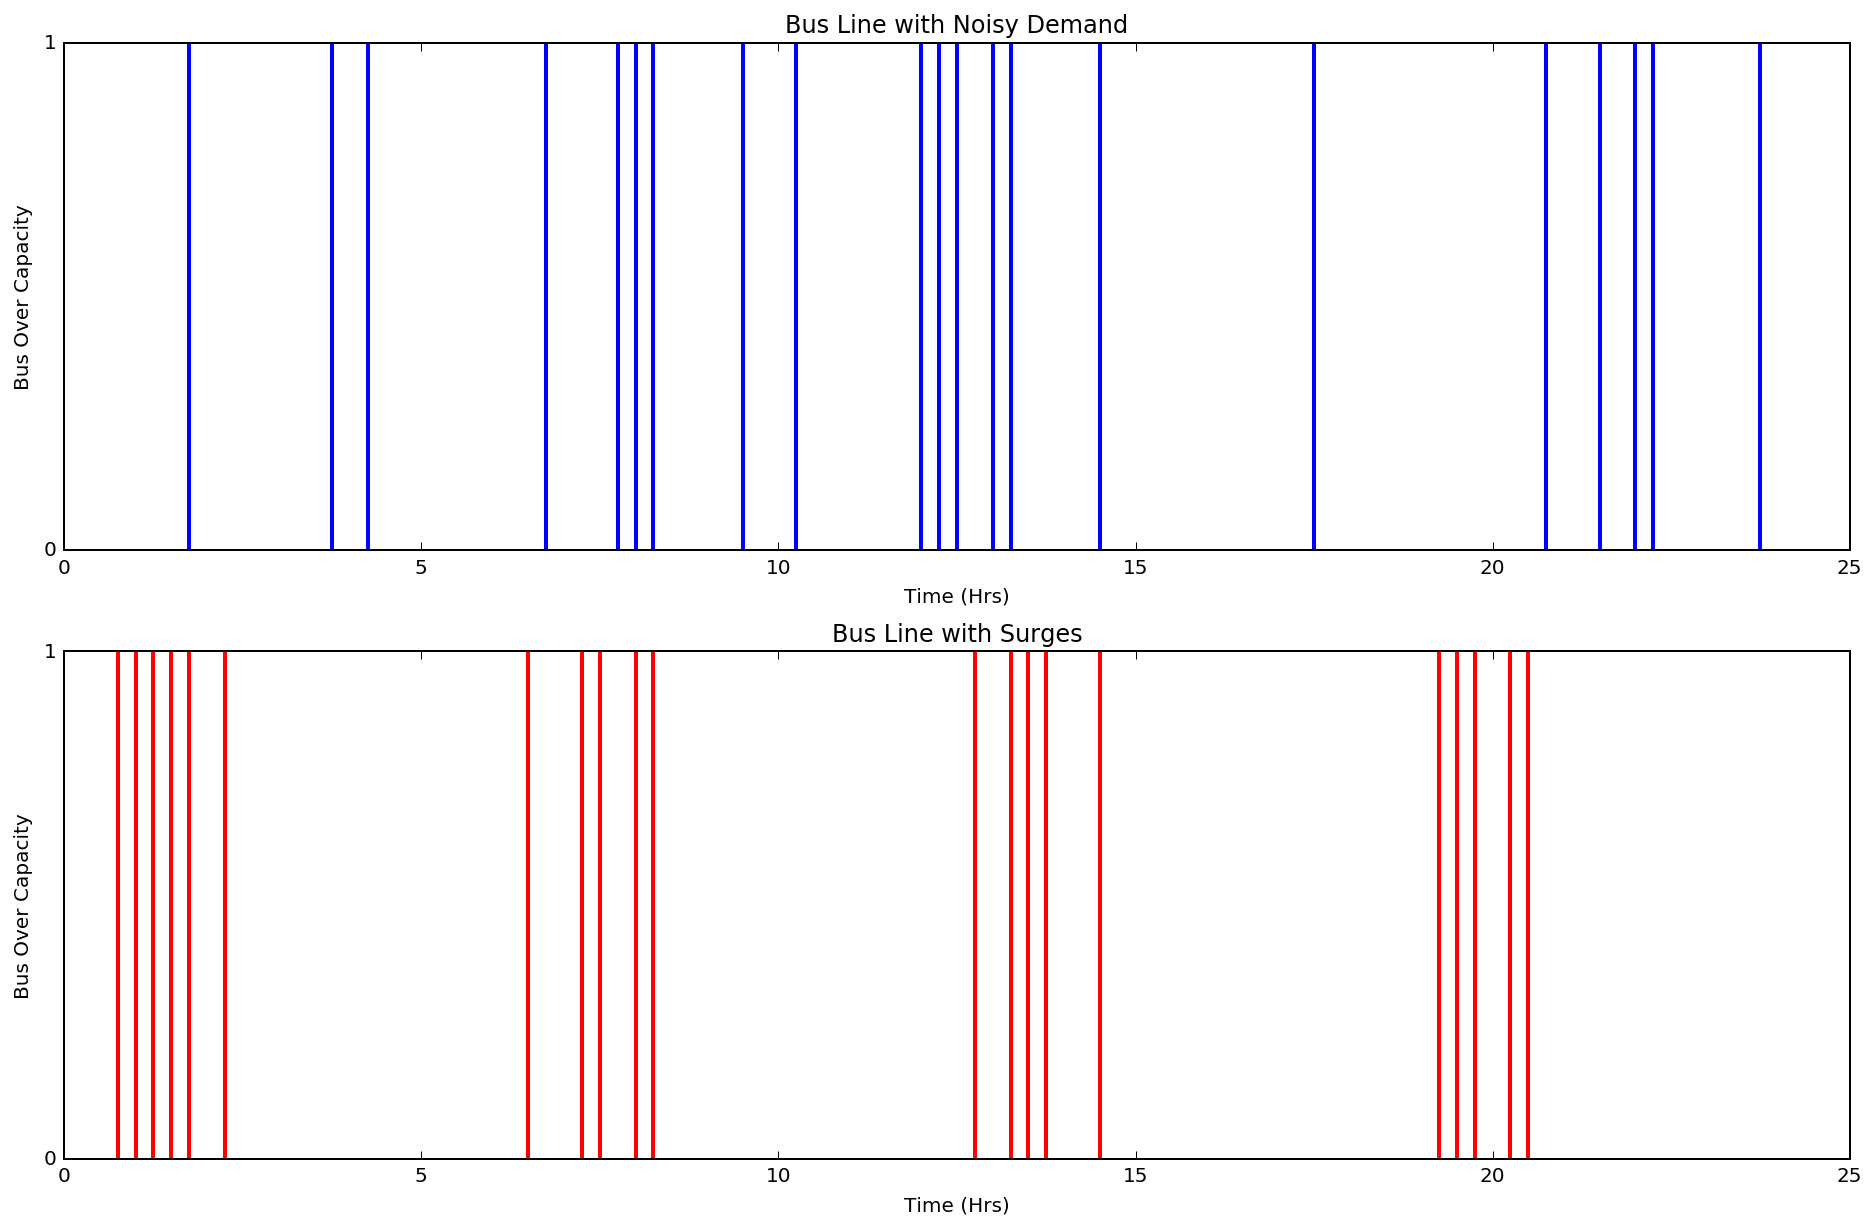

In [6]:
#Clearly these look different 
noisy_demand,_ = sim_demand(ti,4,surge_shift = 0, surge_coeff = 0,noise_coeff = 1,demand_coeff= 20)
surging_demand,_ = sim_demand(ti,4,surge_shift = 0, surge_coeff = 1,noise_coeff = 0.5,demand_coeff= 20)

fig = plt.figure(figsize = (16,10))
ax1 = fig.add_subplot(2,1,1);
noisy_inds = np.where(noisy_demand == 1);

for x in noisy_inds[0]:
    ax1.plot([ti_hrs[x],ti_hrs[x]],[0,1],'b',linewidth=2)
ax1.set_title('Bus Line with Noisy Demand')
ax1.set_xlabel('Time (Hrs)')
ax1.set_ylabel('Bus Over Capacity')
ax1.set_yticks([0,1])

ax2 = fig.add_subplot(2,1,2);
surging_inds = np.where(surging_demand == 1);
for x in surging_inds[0]:
    ax2.plot([ti_hrs[x],ti_hrs[x]],[0,1],'r',linewidth=2)
ax2.set_title('Bus Line with Surges')
ax2.set_xlabel('Time (Hrs)')
ax2.set_ylabel('Bus Over Capacity')
ax2.set_yticks([0,1])

plt.savefig('/Users/Torben/Code/sdsmartcityhackathon/noisy_vs_surge_bus.jpg',format='jpg',dpi=300)

# Coefficient of Variation (CV) in inter-spike intervals is a measure for how "bursty" a point process is

In [7]:
#Are these demands constant or periodic?
all_varience_in_isis = [];
ti = np.arange(0,total_time_steps*10)
def calc_varience(this_sim):
    """
    Calcualtes the coefficient of variation in the time intervals in a point process
    
    Inputs:
    this_sim: a 1 x N boolean array of timepoints where 1 is a full bus and 0 is a bus that isn't full

    Returns:
    CV: the coefficient of variation
    """
    
    inds = np.where(this_sim == 1)[0];
    #isis= interspike intervals, not the terrorist organization
    isis = np.diff(inds);
    if len(isis)>0 and sum(isnan(isis)==0):
        CV = scipy.stats.variation(isis)
        if np.isfinite(CV):
            return CV
        else:
            return 0
    else:
        return 0


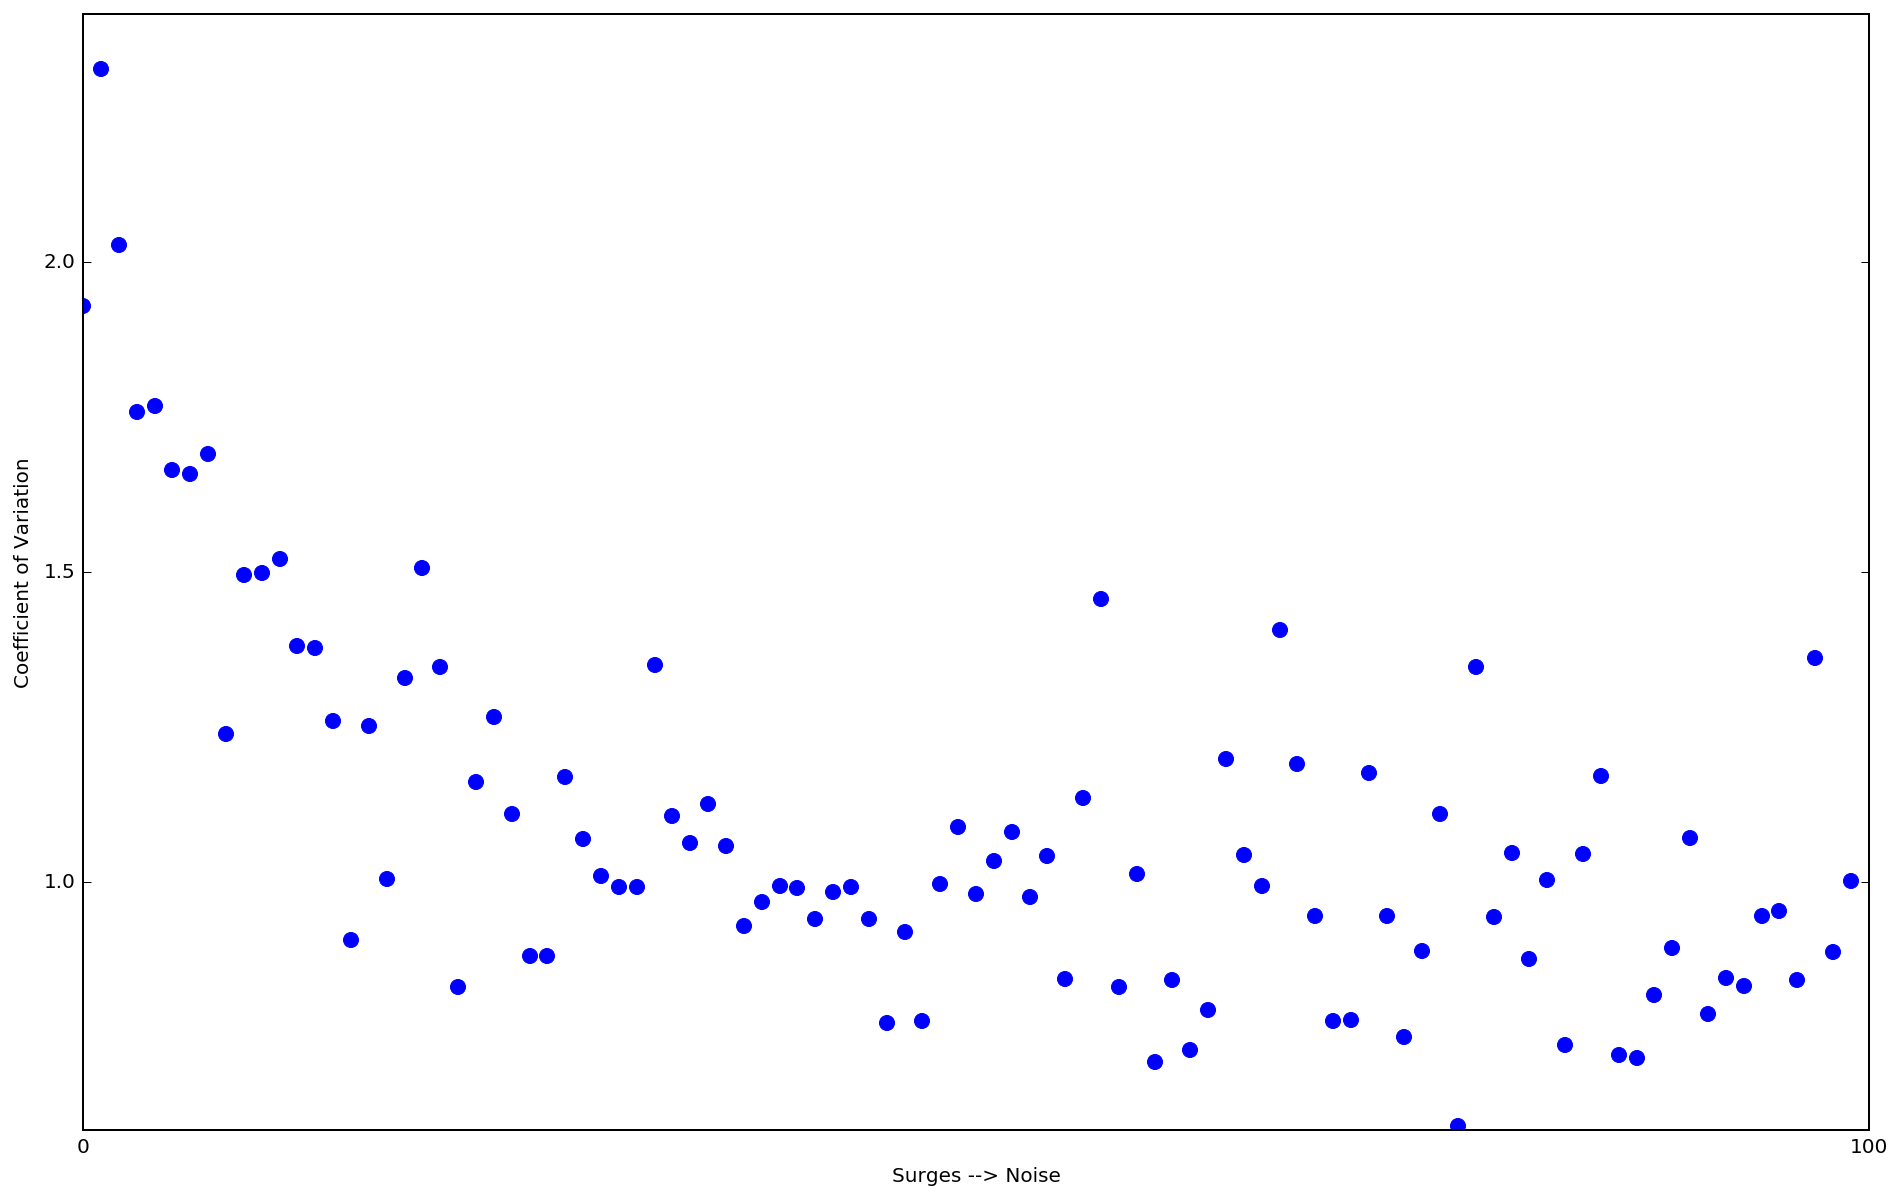

In [8]:
#make data with a range of burstiness
figure(figsize = (16,10))
all_cvs = []
all_x = []
for x in xrange(100):
    this_dat,_ = sim_demand(ti,5,surge_shift = 0, surge_coeff = 1/(x+0.1),noise_coeff = 1-1/(x+0.1),demand_coeff=30)
    CV = calc_varience(this_dat)
    all_x.append(x)
    all_cvs.append(CV)
    
plt.plot(all_x,all_cvs,'.',markersize=15)
plt.ylabel('Coefficient of Variation')
plt.xlabel('Surges --> Noise')
plt.xticks([0,100]);
plt.savefig('/Users/Torben/Code/sdsmartcityhackathon/cv_analysis.jpg',format='jpg',dpi=300)

# If demand for a bus route surges, can we tell how many times it surges and when those happen?

### Yes. With the power of  K-means

In [9]:
#shitty kmeans that doesn't really work
def calc_surges_vanilla(this_dat):
    """Classic elbow method to find optimal number of peaks but it doesn't work very well"""
    inertias = [];
    centroids = [0];
    inds = np.where(this_dat == 1)[0];
    if sum(this_dat)>2:
        #kmeans breaks if it is an array of zeros
        for k in xrange(1,10):
            k_means = KMeans(n_clusters=k, random_state=0)
            k_means.fit_predict(np.expand_dims(inds,1))
            inertias.append(k_means.inertia_)
            centroids.append(k_means.cluster_centers_)
        delta_inertias = np.diff(inertias[1:])
        #plt.plot(delta_inertias)
        this_many_peaks = argmax(delta_inertias)
        #print this_many_peaks
        these_centroids = centroids[this_many_peaks+1]
        return this_many_peaks,these_centroids
    else:
        print 'not enough busses filled to analyze'
        return 0, []

#good kmeans taht works
def calc_surges(this_dat,max_clusters=10,k_thresh=5):
    """my tweaked kmeans thats better"""

    inds = np.where(this_dat == 1)[0];
    if sum(this_dat)>2:
        #kmeans breaks if it is an array of zeros
        k_means = KMeans(n_clusters=max_clusters, random_state=0)
        k_means.fit_predict(np.expand_dims(inds,1))
        centroids=k_means.cluster_centers_
        sorted_centroids = [i for i in sorted([k[0] for k in centroids])]
        diffs = np.diff(sorted_centroids)
        splits = np.where(diffs>k_thresh)
        new_centroids = []
        i = 0
        for s in splits[0]:
            group = sorted_centroids[i:s+1]
            new_centroids.append(np.mean(group))
            i=s+1;
        group = sorted_centroids[i:]
        new_centroids.append(np.mean(group))
        return len(new_centroids),new_centroids
    else:
        print 'not enough busses filled to analyze'
        return 0, []

[24.625, 56.0, 87.666666666666671]


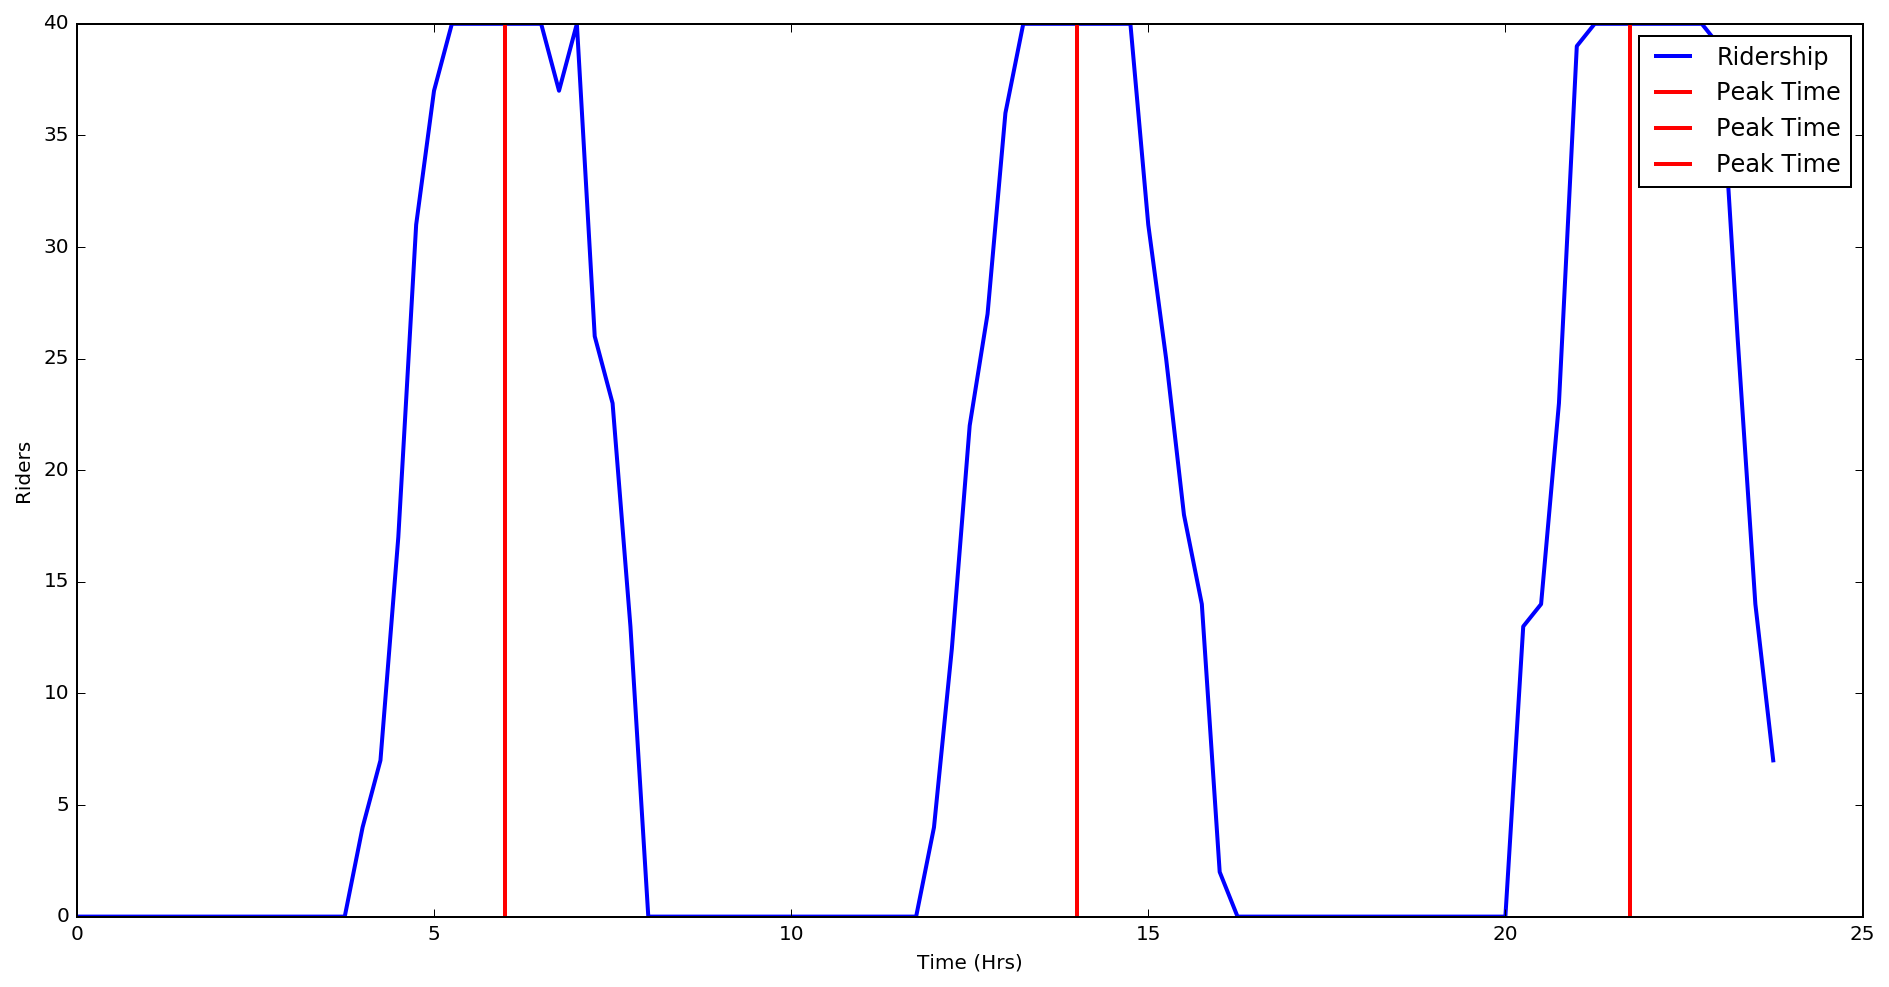

In [10]:
#can we tell you how surge-ey a bus stop is?
#Yes. 
total_time_steps = 24*4; #15 minutetime resolution time steps
ti = np.arange(0,total_time_steps)
plt.figure(figsize = (16,8))
this_dat,riders = sim_demand(ti,3,surge_shift = 0, surge_coeff = 1,noise_coeff = .1,demand_coeff=20)
ncenters,centers = calc_surges(this_dat)
print centers
plt.plot(ti_hrs,riders,label='Ridership',linewidth=2)
plt.ylabel('Riders')
plt.xlabel('Time (Hrs)')

for c in xrange(ncenters):
    plt.plot([ti_hrs[int(np.floor(centers[c]))],ti_hrs[int(np.floor(centers[c]))]],[0,max(riders)],'r',linewidth = 2, label='Peak Time')
plt.legend()

plt.savefig('/Users/Torben/Code/sdsmartcityhackathon/kmeans_example.jpg',format='jpg',dpi=300)

### How well can my K-means find surges in simulated data?

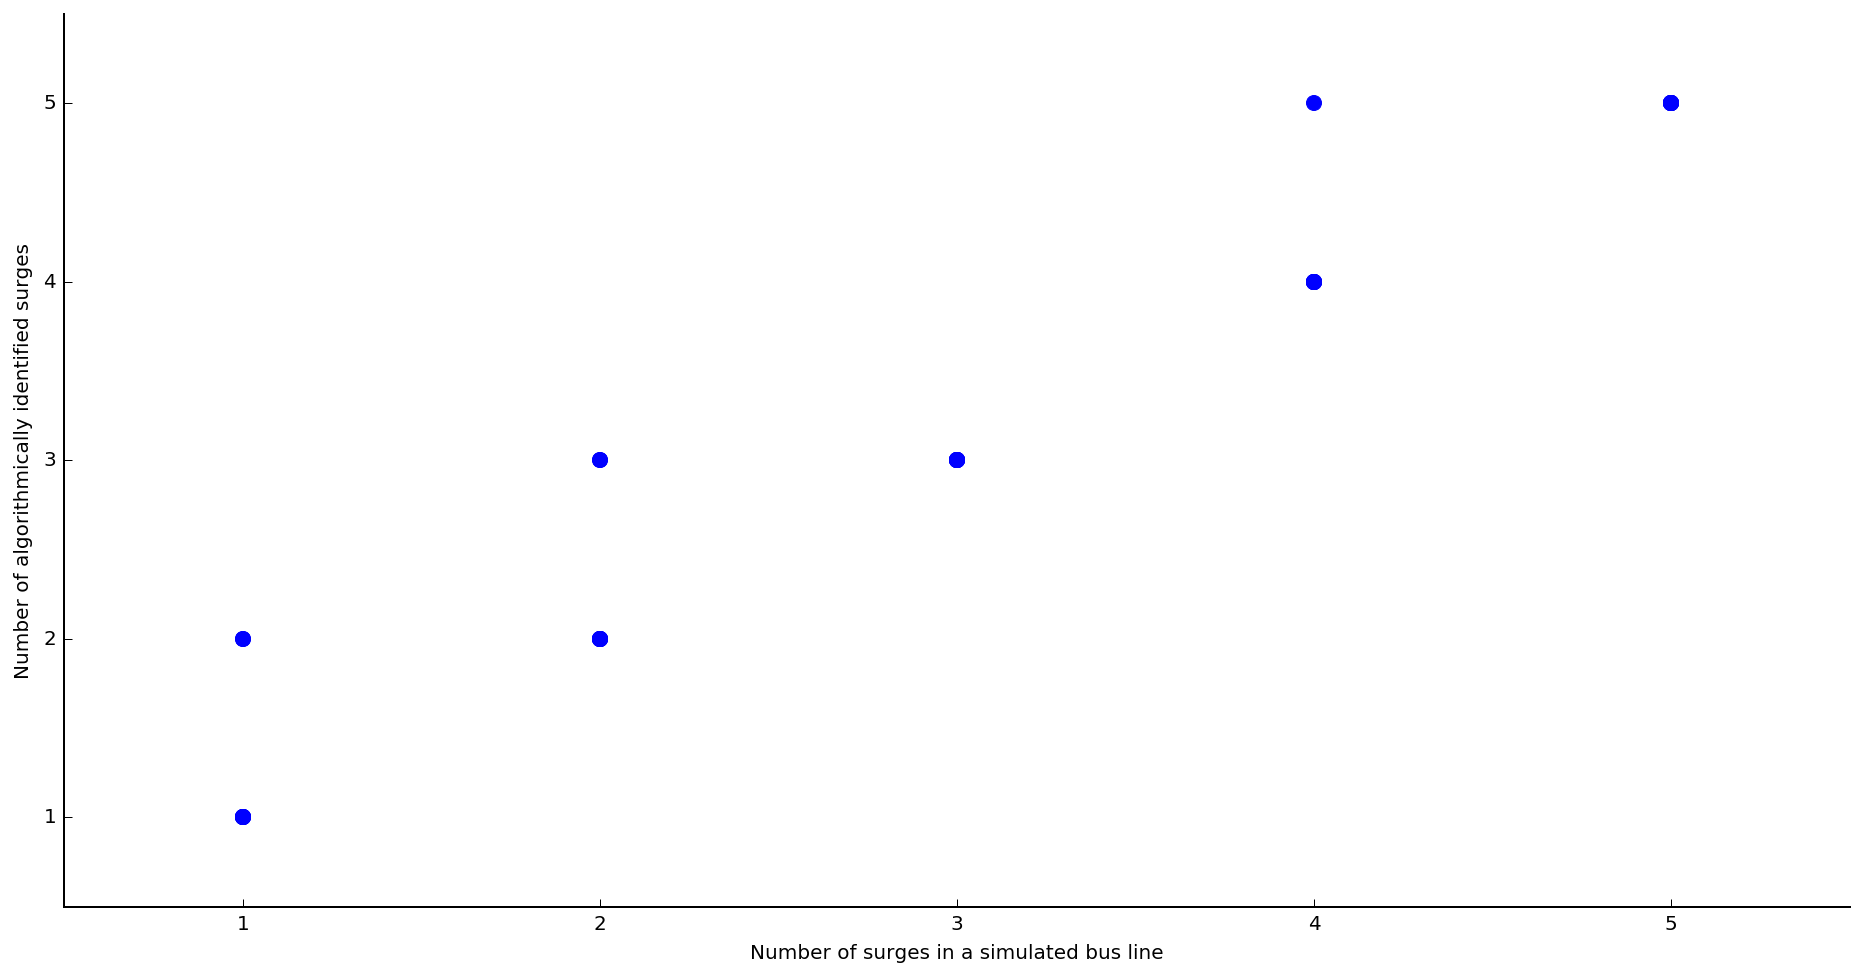

In [11]:
nsurges = np.zeros(50)
surges = np.zeros(50)
surges[0:10] = 1;
surges[10:20] = 2;
surges[20:30] = 3;
surges[30:40] = 4;
surges[40:50] = 5;

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
for x in xrange(len(surges)):
    this_dat,r = sim_demand(ti,surges[x],surge_shift =0, surge_coeff = 1,noise_coeff = .5,demand_coeff=15)
    nsurge,_ = calc_surges(this_dat)
    nsurges[x] = nsurge
ax.plot(surges,nsurges,'.',markersize=15)
ax.set_xlabel('Number of surges in a simulated bus line')
ax.set_ylabel('Number of algorithmically identified surges')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylim([.5,5.5])
ax.set_xlim([.5,5.5])
plt.savefig('/Users/Torben/Code/sdsmartcityhackathon/validating_kmeans.png',format='png',dpi=300)

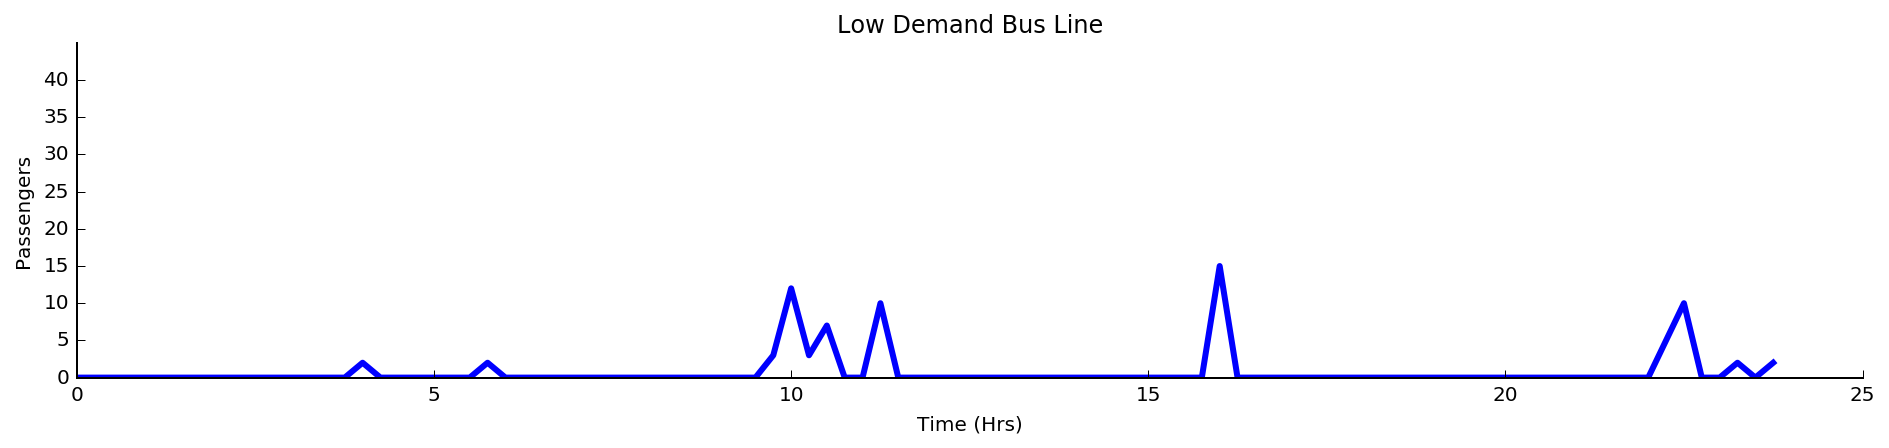

In [12]:
#bonus cell for making pretty figures
total_time_steps = 24*4; #15 minutetime resolution time steps
ti = np.arange(0,total_time_steps)
ti_hrs = [i/4.0 for i in ti] #time axis in hourse for time series above

alarms,this_dat = sim_demand(ti,4,surge_shift = 0, surge_coeff = 1 ,noise_coeff = 1, demand_coeff=-25,max_cap = 40)
inds = np.where(alarms == 1);
fig, ax = plt.subplots(figsize = (16,3))
ax.plot(ti_hrs,this_dat,linewidth=3,color='b');
for ind in inds[0]:
    ax.plot(ti_hrs[ind],max(this_dat)+3,'r.')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('Time (Hrs)')
ax.set_ylabel('Passengers')
ax.set_ylim([0,45])
ax.set_yticks([0,5,10,15,20,25,30,35,40])
ax.set_title('Low Demand Bus Line')
plt.show()

plt.show()